In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import sys
import math

In [2]:
import os
os.getcwd()

'/home/pratik/notebook/tweetProj/TweetProj/Conventional'

In [3]:
path = '../Dataset/Embedding/'
outputFilename = 'ConventionalOutput2.csv'
with open(outputFilename, 'w') as f:
    print('modelname,Accuracy, precision, recall, fscore, Roc-AUC',file=f)

In [4]:
datasetName = ['kolkata_WE_100.csv',
               'delhi_WE_100.csv',
               'kolkata_infercent_4096.csv',
               'delhi_infercent_4096_2.csv'
              ]
labelName = ['kolkata_classLabel_named.csv',
             'delhi_classLabel.csv',
             'kolkata_classLabel_named.csv',
             'delhi_classLabel.csv']

In [5]:
def getDataSet(fileName,labelName):
    X = pd.read_csv(path+fileName)
    Y = pd.read_csv(path+labelName).iloc[:,-1:]
    return X,Y

In [6]:
def getBalancedDataSet(fileName,labelName):
    X,Y = getDataSet(fileName,labelName)
    average_y = math.ceil(np.average(Y.label.value_counts()))
    df = X.copy()
    df['label'] = Y.values
    
    sampled_df = {}
    for i in np.unique(df.label):
        sampled_df[i] = df[(df.label == i)]
        
    df_balanced_sample = {}
    for i in np.unique(df.label):
        df_balanced_sample[i] = resample(sampled_df[i], replace=True,n_samples= average_y,random_state=42)
        
    append_data = []
    for i in np.unique(df.label):
        append_data.append(df_balanced_sample[i])

    df_balanced = pd.concat(append_data)
    balancedX = df_balanced.iloc[:,:-1]
    balancedY = df_balanced.iloc[:,-1]
    return balancedX,balancedY
    

In [7]:
def createModel(modelName):
    if modelName == 'lr':
        model = LogisticRegression()
    elif modelName == 'gnb':
        model = GaussianNB()
    elif modelName == 'svm':
        model = SVC(probability=True)
    elif modelName == 'sgd':
        model = SGDClassifier(loss="modified_huber", shuffle = True)
    elif modelName == 'adaboost':
        model = AdaBoostClassifier(n_estimators=100, random_state=0)
    elif modelName == 'gboost':
        model = GradientBoostingClassifier(n_estimators=100, random_state=0)
    elif modelName == 'xgboost':
        model = XGBClassifier(objective="multi:softprob", random_state=0)
    return model      

In [8]:
def plot_confusion_matrix(cm,modelName,dataset,labels):
    plt.figure(figsize = (4, 3))
    cm = pd.DataFrame(cm , index = [i for i in labels] , columns = [i for i in labels])
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix: '+modelName+'_'+dataset, size=14)
    plt.xlabel('Predicted Labels', size=10)
    plt.ylabel('Actual Labels', size=10)
    plt.show()

In [9]:
def run(modelNamelist,dataSet,labelName):
#     X,Y = getBalancedDataSet(dataSet,labelName)
    X,Y = getDataSet(dataSet,labelName)
    labels = Y.label.unique()
    le = LabelEncoder()
    Y1 = le.fit_transform(Y)
    x_train, x_test, y_train, y_test = train_test_split(X,  Y['label'])
    x1_train, x1_test, y1_train, y1_test = train_test_split(X, Y1)
    
    for modelName in modelNamelist:
        model = createModel(modelName)
#         print(model)
        if modelName != 'xgboost':
            Y_train = y_train
            Y_test = y_test
            X_train = x_train
            X_test = x_test
        else:
            Y_train = y1_train
            Y_test = y1_test
            X_train = x1_train
            X_test = x1_test
        
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        pred_prob = model.predict_proba(X_test)

        cm = confusion_matrix(Y_test, y_pred)
        plot_confusion_matrix(cm,modelName,dataSet,labels)
        accuracy = accuracy_score(Y_test, y_pred)
        precision, recall, fscore,_  = score(Y_test, y_pred, average='macro')
        roc_auc = roc_auc_score(Y_test, pred_prob,multi_class='ovr')

        print('ModelName:',modelName,' Dataset: ',dataSet+'\n')
        print('\tAccuracy, precision, recall, fscore, Roc-AUC')
        print('\t{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))
        print('=============================================================================================')
        
        with open(outputFilename, 'a') as f:
            print('{},{},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(modelName,dataSet,accuracy,precision,recall,fscore,roc_auc), file=f)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


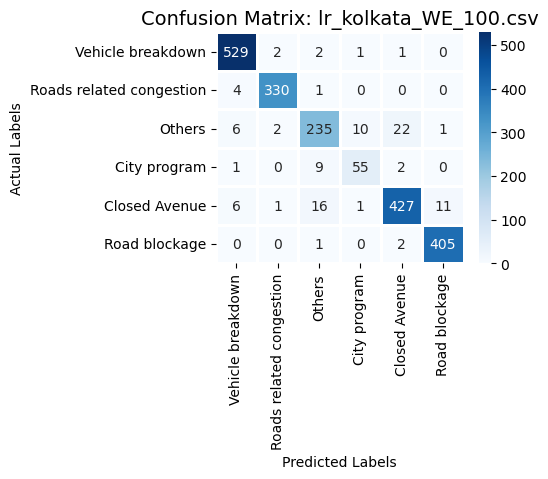

ModelName: lr  Dataset:  kolkata_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.951,0.929,0.927,0.928,0.994
GaussianNB()


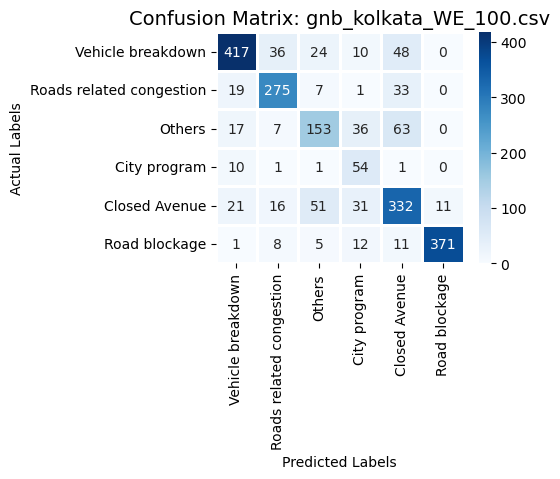

ModelName: gnb  Dataset:  kolkata_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.769,0.720,0.765,0.728,0.950
SVC(probability=True)


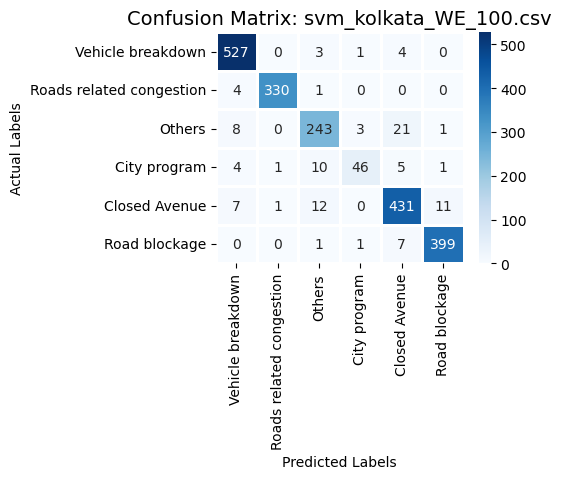

ModelName: svm  Dataset:  kolkata_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.949,0.941,0.908,0.922,0.994
SGDClassifier(loss='modified_huber')


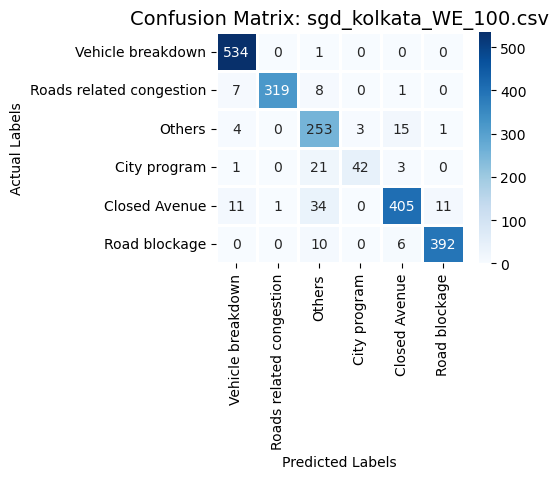

ModelName: sgd  Dataset:  kolkata_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.934,0.929,0.889,0.902,0.960
AdaBoostClassifier(n_estimators=100, random_state=0)


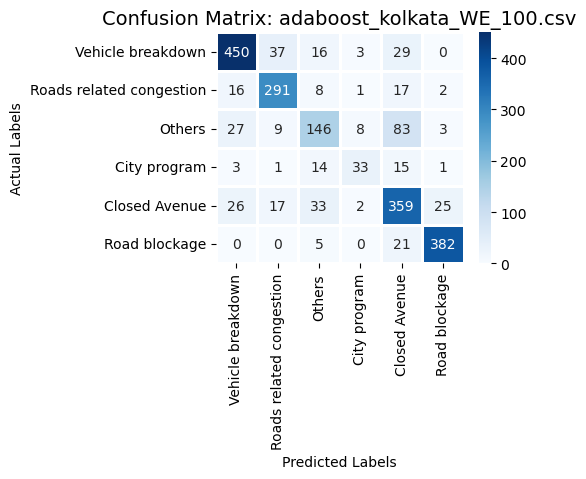

ModelName: adaboost  Dataset:  kolkata_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.797,0.775,0.741,0.753,0.884
GradientBoostingClassifier(random_state=0)


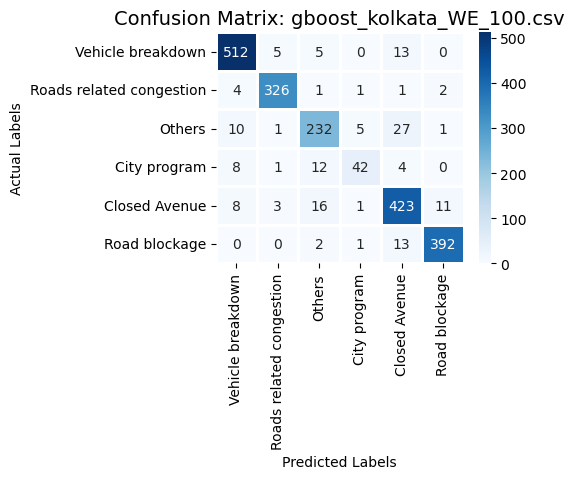

ModelName: gboost  Dataset:  kolkata_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.925,0.911,0.879,0.892,0.992
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


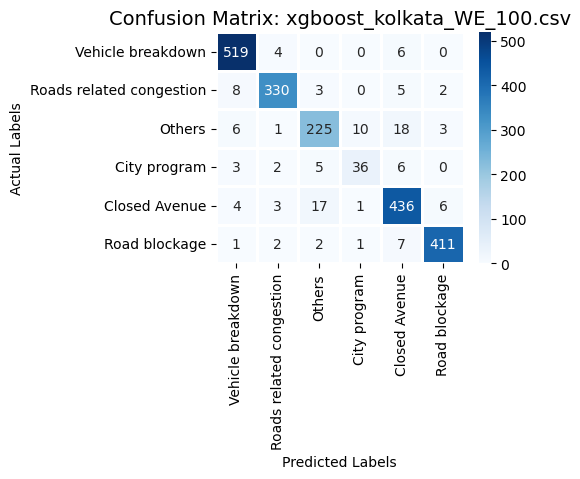

ModelName: xgboost  Dataset:  kolkata_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.940,0.909,0.897,0.902,0.995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


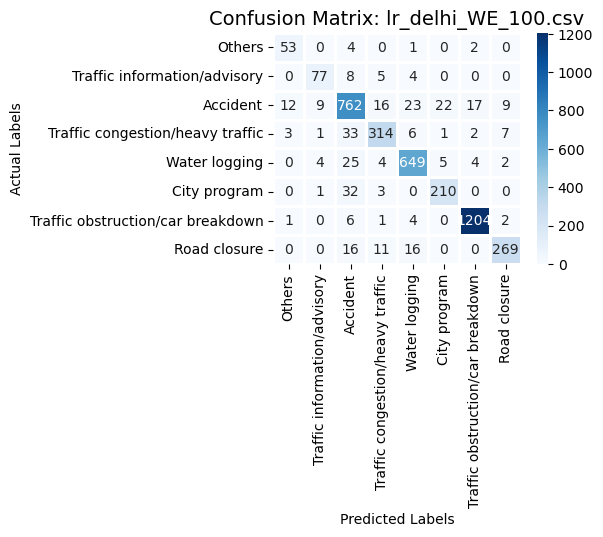

ModelName: lr  Dataset:  delhi_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.917,0.884,0.884,0.883,0.989
GaussianNB()


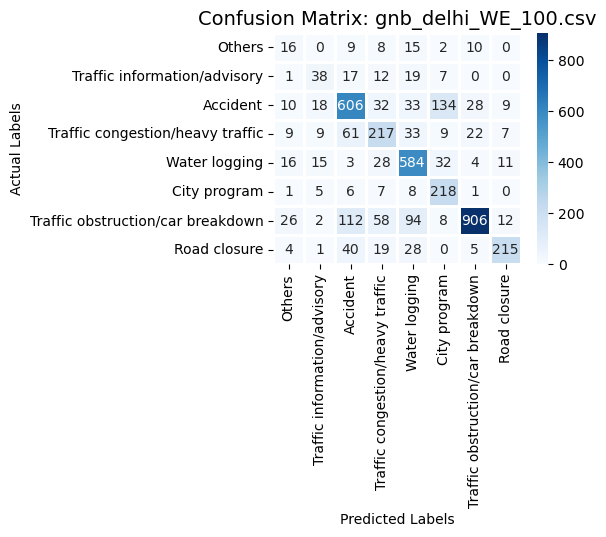

ModelName: gnb  Dataset:  delhi_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.725,0.616,0.640,0.619,0.913
SVC(probability=True)


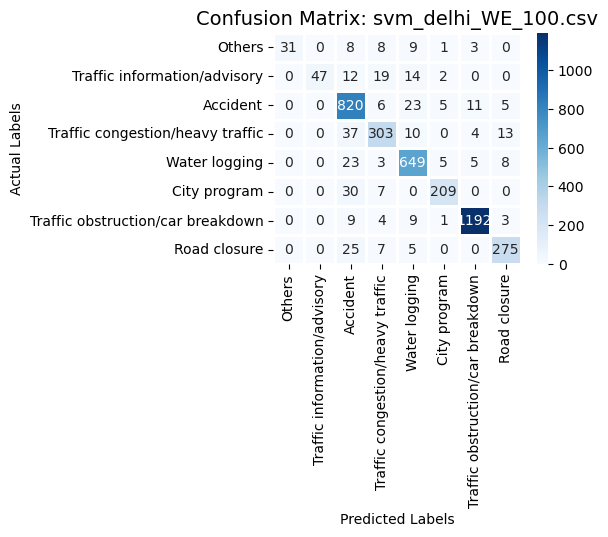

ModelName: svm  Dataset:  delhi_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.913,0.928,0.804,0.845,0.992
SGDClassifier(loss='modified_huber')


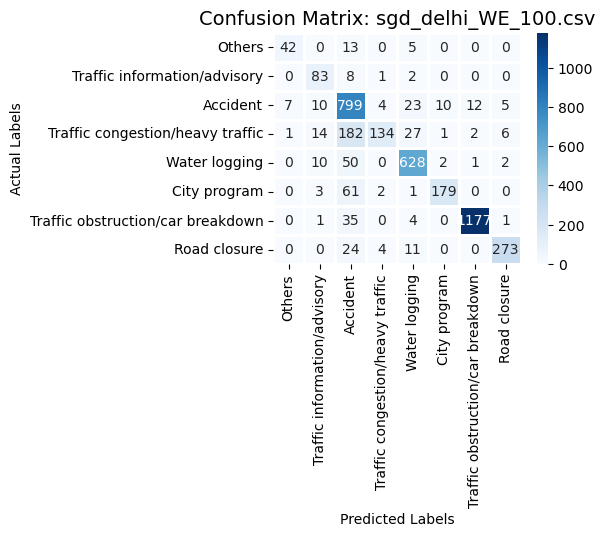

ModelName: sgd  Dataset:  delhi_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.859,0.862,0.793,0.806,0.912
AdaBoostClassifier(n_estimators=100, random_state=0)


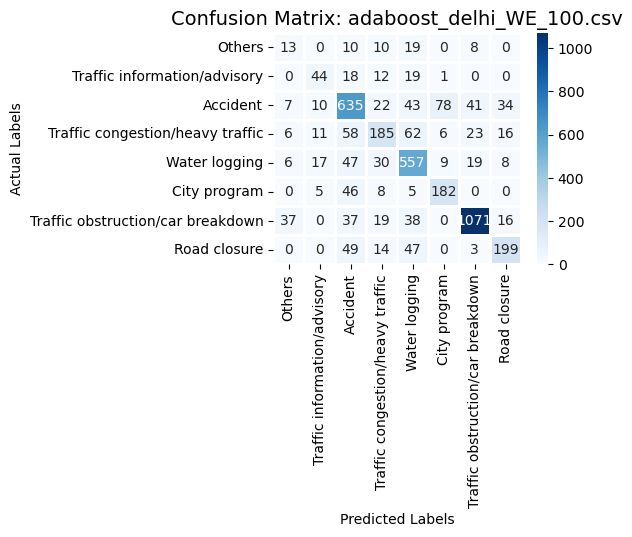

ModelName: adaboost  Dataset:  delhi_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.748,0.629,0.622,0.623,0.879
GradientBoostingClassifier(random_state=0)


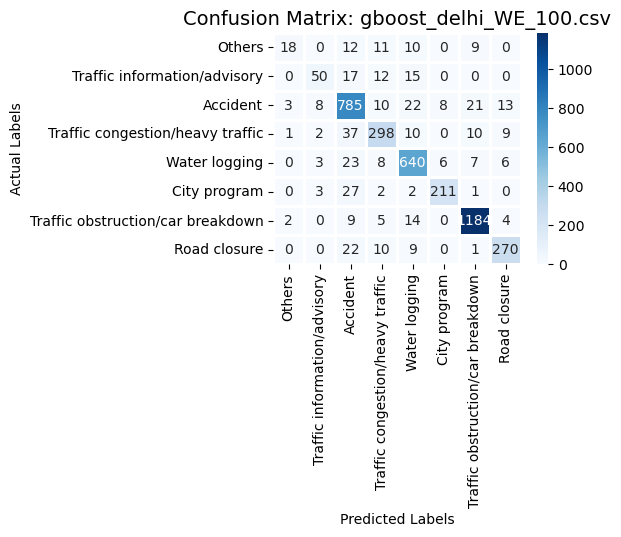

ModelName: gboost  Dataset:  delhi_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.895,0.858,0.771,0.799,0.986
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


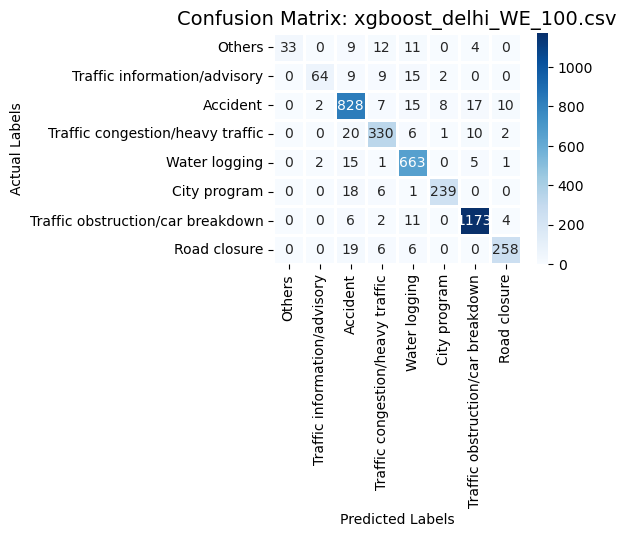

ModelName: xgboost  Dataset:  delhi_WE_100.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.930,0.937,0.837,0.872,0.993


/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


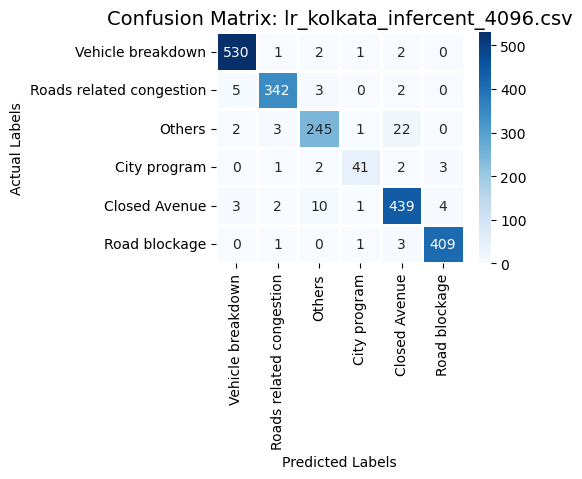

ModelName: lr  Dataset:  kolkata_infercent_4096.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.963,0.954,0.940,0.946,0.997
GaussianNB()


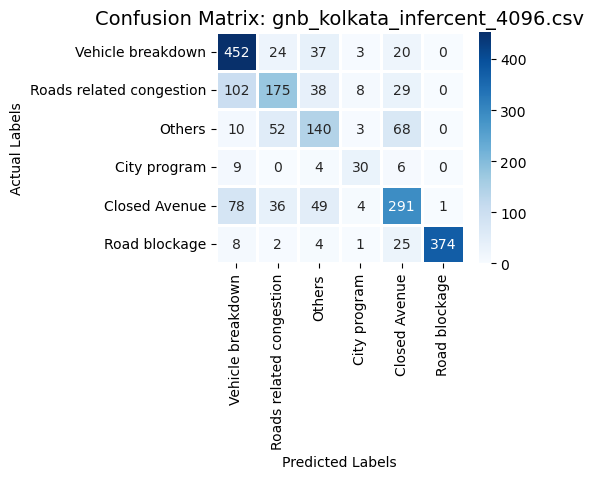

ModelName: gnb  Dataset:  kolkata_infercent_4096.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.702,0.680,0.667,0.671,0.899
SVC(probability=True)


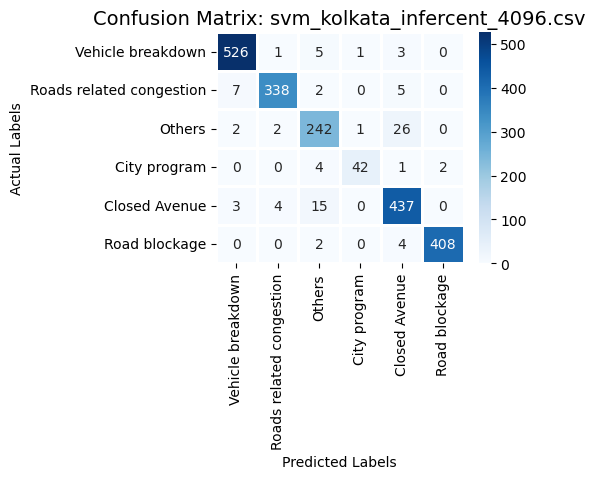

ModelName: svm  Dataset:  kolkata_infercent_4096.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.957,0.954,0.937,0.945,0.996
SGDClassifier(loss='modified_huber')


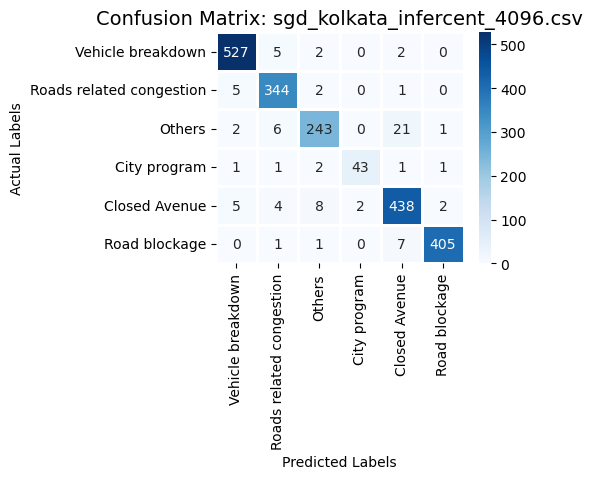

ModelName: sgd  Dataset:  kolkata_infercent_4096.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.960,0.958,0.943,0.950,0.980
AdaBoostClassifier(n_estimators=100, random_state=0)


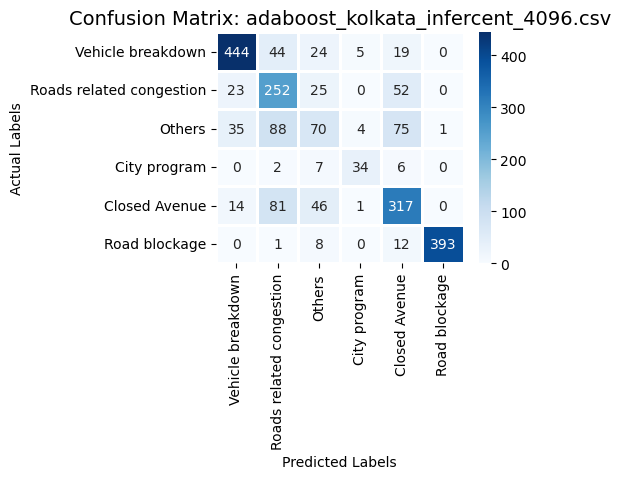

ModelName: adaboost  Dataset:  kolkata_infercent_4096.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.725,0.703,0.689,0.691,0.810
GradientBoostingClassifier(random_state=0)


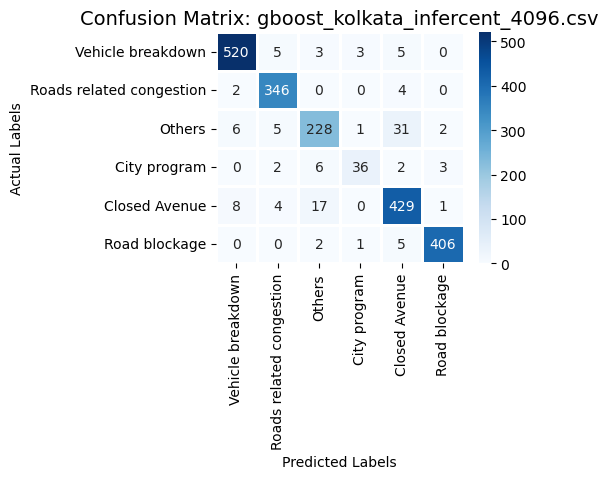

ModelName: gboost  Dataset:  kolkata_infercent_4096.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.943,0.930,0.906,0.917,0.996
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


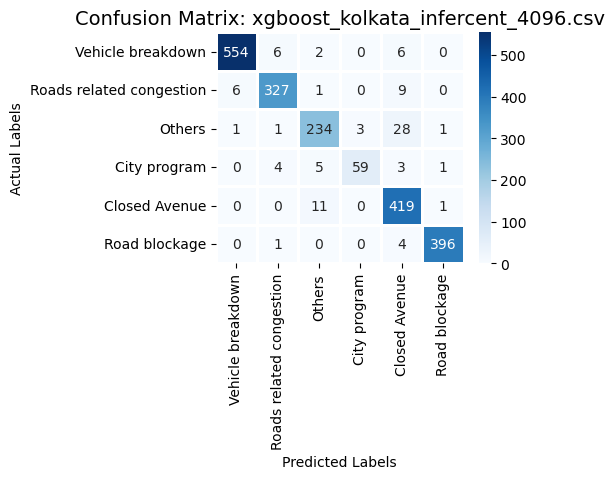

ModelName: xgboost  Dataset:  kolkata_infercent_4096.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.955,0.952,0.930,0.940,0.997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


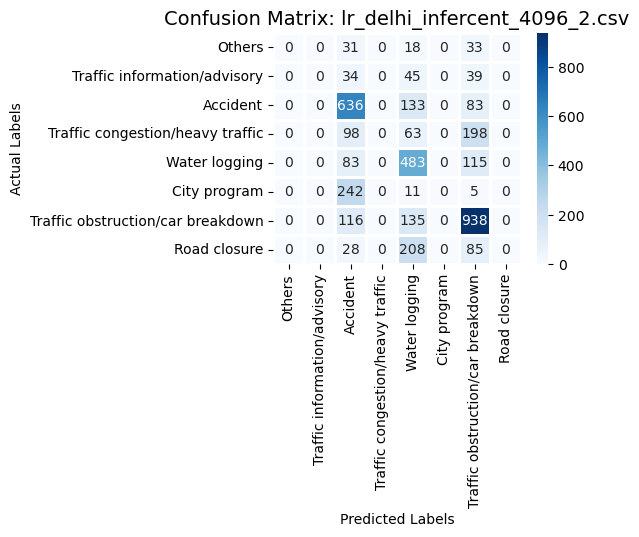

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ModelName: lr  Dataset:  delhi_infercent_4096_2.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.533,0.196,0.281,0.230,0.779
GaussianNB()


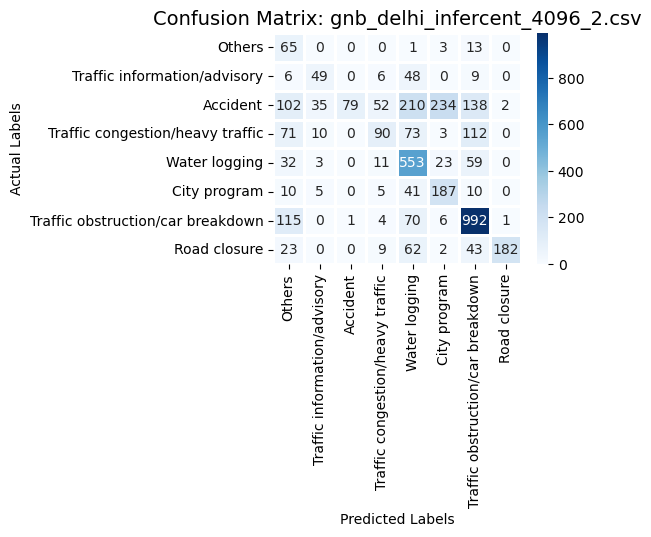

ModelName: gnb  Dataset:  delhi_infercent_4096_2.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.569,0.596,0.561,0.482,0.920
SVC(probability=True)


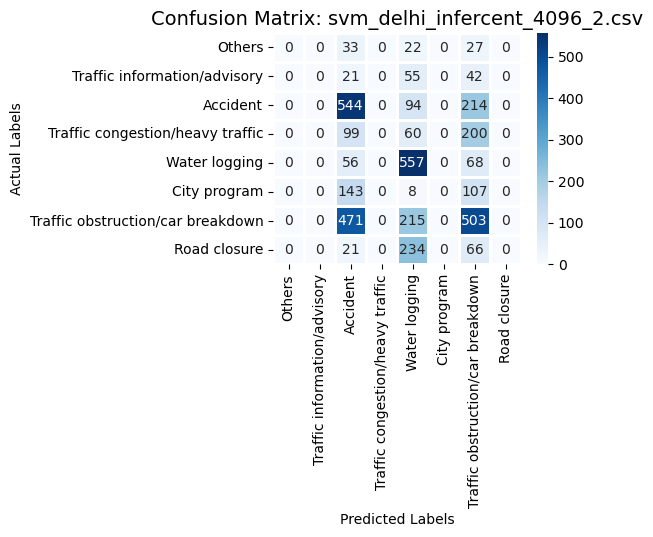

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ModelName: svm  Dataset:  delhi_infercent_4096_2.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.416,0.156,0.235,0.185,0.676
SGDClassifier(loss='modified_huber')


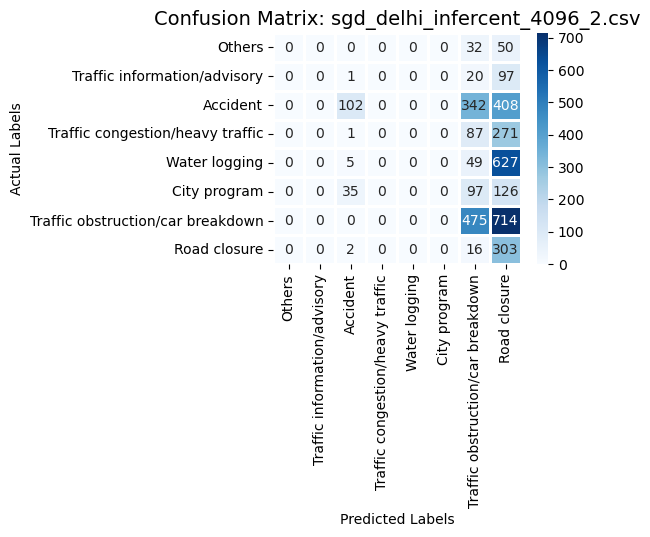

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ModelName: sgd  Dataset:  delhi_infercent_4096_2.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.228,0.155,0.183,0.103,0.539
AdaBoostClassifier(n_estimators=100, random_state=0)


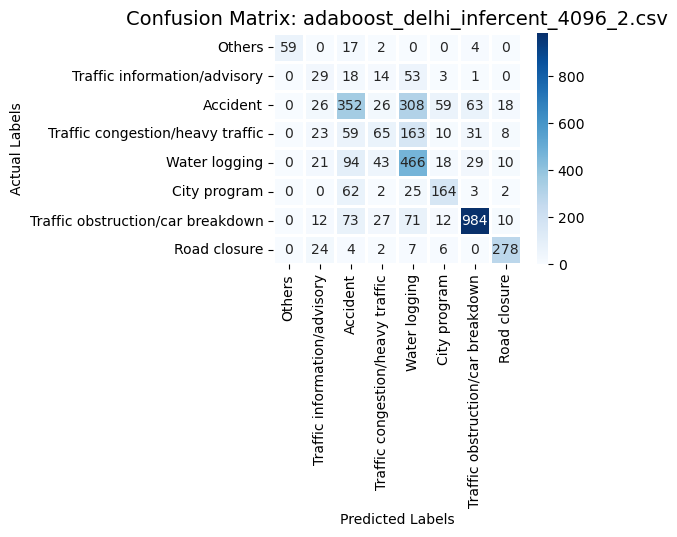

ModelName: adaboost  Dataset:  delhi_infercent_4096_2.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.621,0.607,0.572,0.578,0.820
GradientBoostingClassifier(random_state=0)


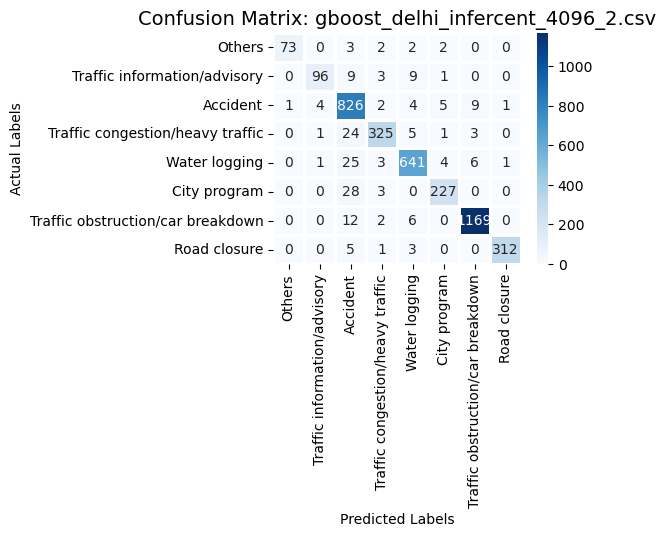

ModelName: gboost  Dataset:  delhi_infercent_4096_2.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.951,0.956,0.919,0.936,0.996
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


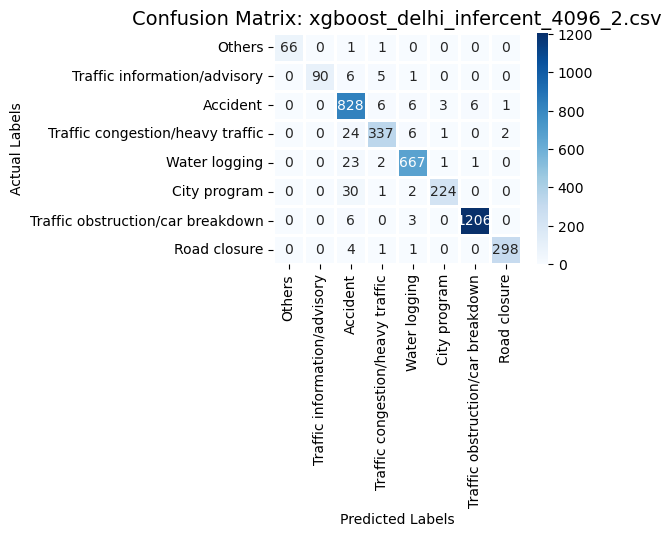

ModelName: xgboost  Dataset:  delhi_infercent_4096_2.csv

	Accuracy, precision, recall, fscore, Roc-AUC
	0.963,0.973,0.943,0.957,0.998


In [10]:
modelNamelist =['lr','gnb','svm','sgd','adaboost','gboost','xgboost']
# modelNamelist =['lr']

for index in range(len(datasetName)):
    run(modelNamelist,datasetName[index],labelName[index])